# 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as np

import numpy as onp

import inspect
import os
import sys
import time

sys.path.insert(0, '../')

onp.random.seed(3452453)

In [3]:
from bnpgmm_runjingdev.genomics_utils import spline_bases_lib, regression_lib, transform_regression_lib
from bnpgmm_runjingdev import genomics_data_utils

ModuleNotFoundError: No module named 'bnpgmm_runjingdev.genomics_utils'

In [ ]:
import gmm_plotting_utils

# Load data

In [4]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 
y, _, train_indx, timepoints = genomics_data_utils.load_genomics_data(
    bnp_data_repo, 
    split_test_train = False)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [5]:
n_obs = y.shape[0]
n_t = len(timepoints)
n_t_unique = len(np.unique(timepoints))

print('timepoints: \n ', timepoints, '\n')
print('Distinct timepoints: \n', np.sort(np.unique(timepoints)), '\n')
print('Number of distinct timepoints:', n_t_unique)

timepoints: 
  [0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 18, 18, 18, 24, 24, 24, 30, 30, 30, 36, 36, 36, 48, 48, 48, 60, 60, 60, 72, 72, 72, 120, 120, 120, 168, 168, 168] 

Distinct timepoints: 
 [  0   3   6   9  12  18  24  30  36  48  60  72 120 168] 

Number of distinct timepoints: 14


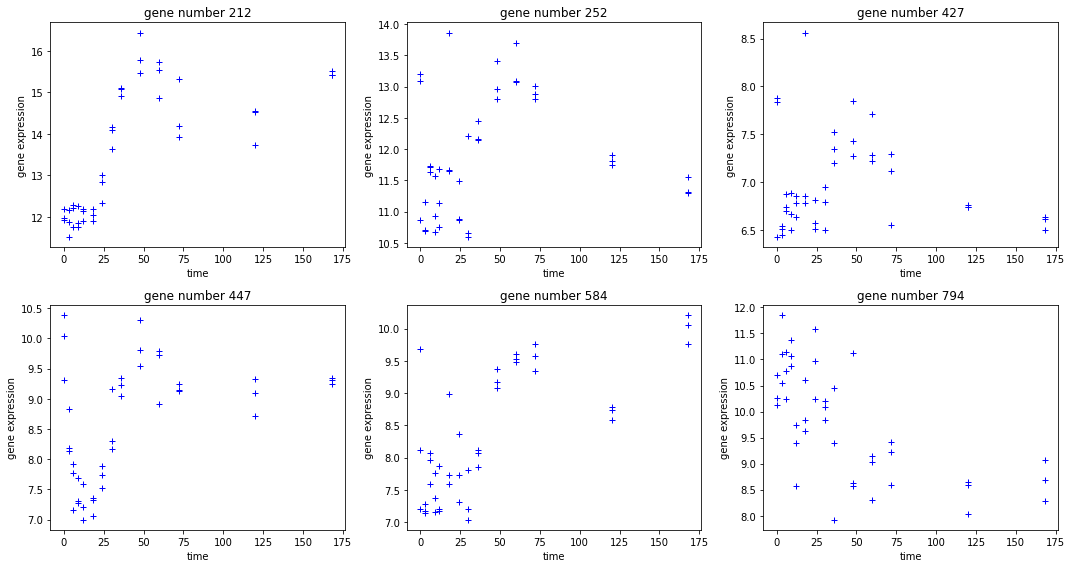

In [6]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = np.sort(onp.random.choice(n_obs, 6))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    this_plot.plot(timepoints, y[n, :].T, '+', color = 'blue');
    this_plot.set_ylabel('gene expression')
    this_plot.set_xlabel('time')
    this_plot.set_title('gene number {}'.format(n))
    
f.tight_layout()

# Run regression

In [7]:
regressors = spline_bases_lib.get_genomics_spline_basis(
    timepoints, df=7, degree=3)

Text(0, 0.5, 'B-splien value')

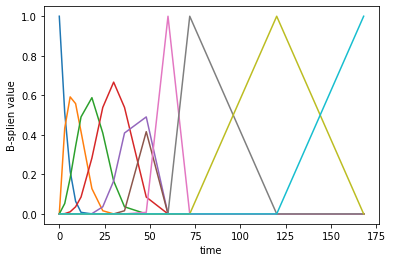

In [8]:
plt.plot(timepoints, regressors);
plt.xlabel('time')
plt.ylabel('B-splien value')

Text(0.5, 1.0, 'The (transposed) regressor matrix')

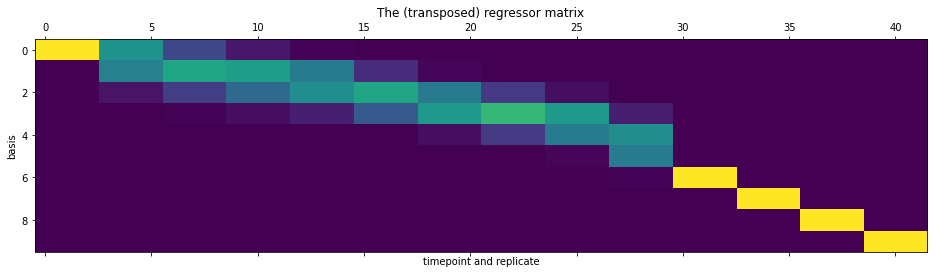

In [9]:
plt.matshow(regressors.T)
plt.ylabel('basis')
plt.xlabel('timepoint and replicate')
plt.title('The (transposed) regressor matrix')

In [10]:
beta, beta_infos, y_infos = regression_lib.run_regressions(y, regressors)

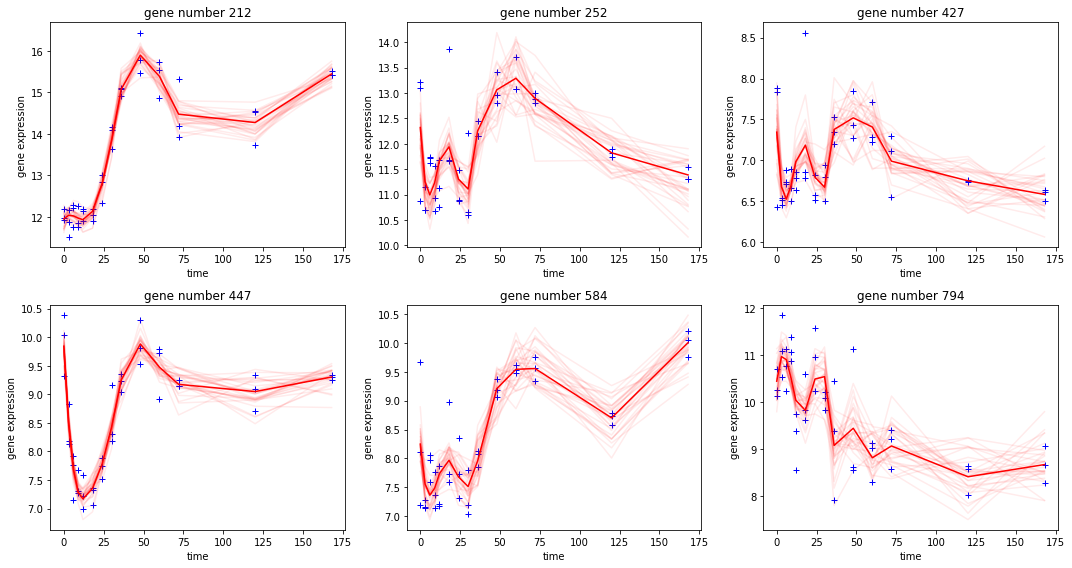

In [11]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    gmm_plotting_utils.PlotRegressionLine(y, timepoints, regressors, beta, beta_infos, n, ax = this_plot)
    
f.tight_layout()


# Transform regression coefficients

In [12]:
# Get the matrix that does the transformation.
transform_mat, unrotate_transform_mat = \
    transform_regression_lib.get_reversible_predict_and_demean_matrix(regressors)
trans_obs_dim = transform_mat.shape[0]

In [13]:
unrotate_transform_mat.shape

(42, 9)

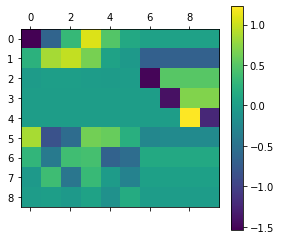

In [14]:
plt.matshow(transform_mat)
plt.colorbar();

In [15]:
beta_transformed, beta_infos_transformed = \
    transform_regression_lib.multiply_regression_by_matrix(beta, beta_infos, transform_mat)

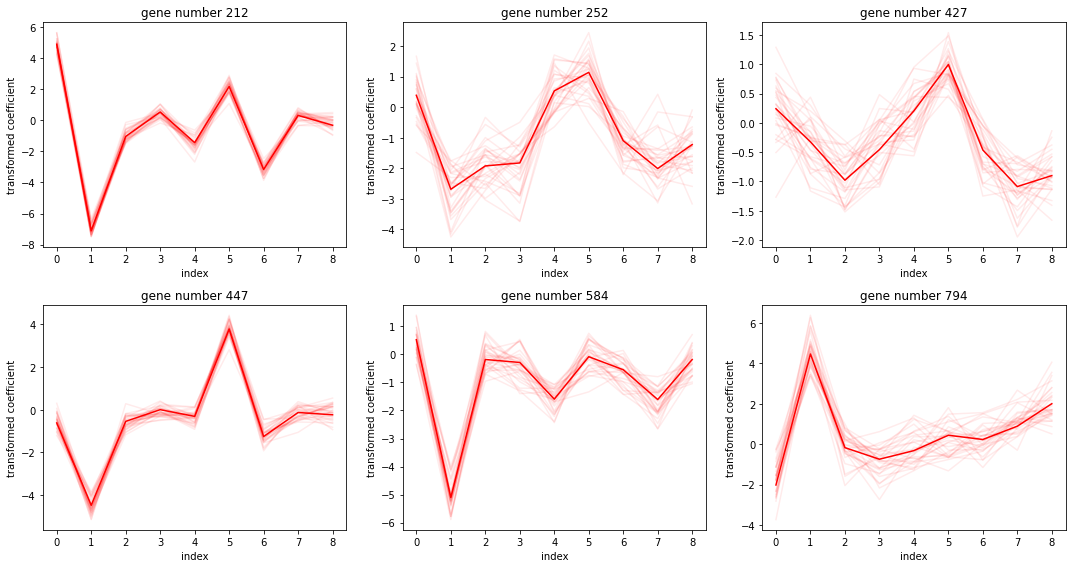

In [16]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(beta_transformed[n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = onp.random.multivariate_normal(
            beta_transformed[n, :], \
             np.linalg.inv(beta_infos_transformed[n]))

        axarr[int(np.floor(i / 3)), i % 3].plot(transformed_beta_draw, 
                                                color = 'red', alpha = 0.08);

f.tight_layout()


In [17]:
pred1 = np.dot(beta_transformed, unrotate_transform_mat.transpose()) + y.mean(1)[:, None]

In [18]:
pred2 = np.dot(beta, regressors.transpose())

In [19]:
assert np.abs(pred2 - pred1).max() < 1e-12

In [20]:
np.abs(pred2 - pred1).max()

DeviceArray(2.13162821e-14, dtype=float64)

# Plot predictions with transformed regression coefficients

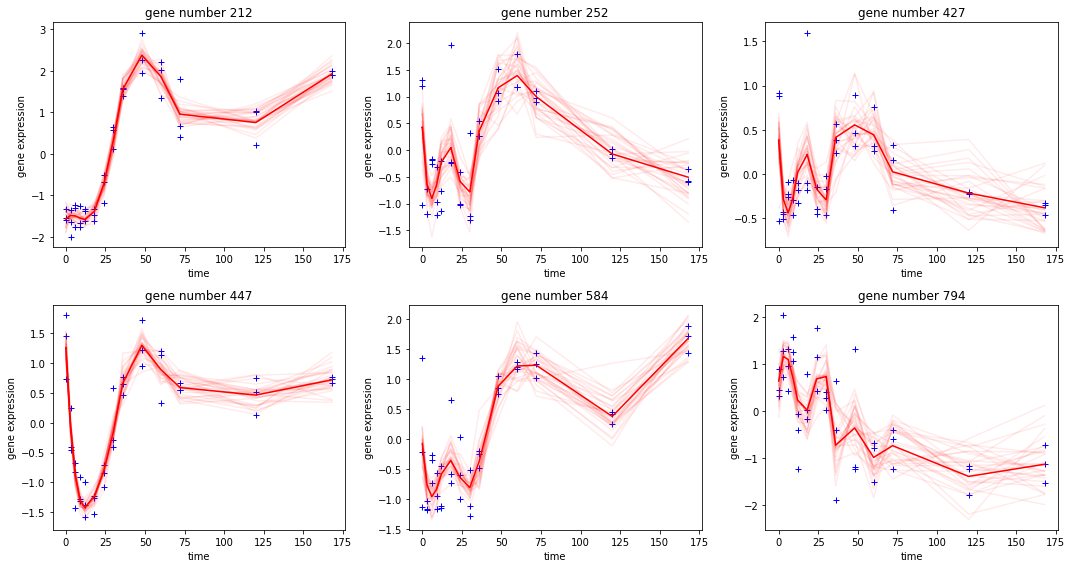

In [21]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    gmm_plotting_utils.PlotRegressionLine(y - y.mean(1)[:, None], 
                                          timepoints,
                                          unrotate_transform_mat,
                                          beta_transformed, 
                                          beta_infos_transformed,
                                          n, ax = this_plot)
    
f.tight_layout()
